In [624]:
import sys, string, pandas as pd, numpy as np, matplotlib.pyplot as plt

In [625]:
import zipfile
with zipfile.ZipFile('./materials.zip', 'r') as zip_ref:
    zip_ref.extractall()

### Comments have been put into this notebook, as comments and markdown files

# Exercise 1


## (a) Univariate decision Boundary

In [626]:
dem_train_og = pd.read_csv('./Dementia_train.csv')
dem_test_og = pd.read_csv('./Dementia_test.csv')

# Remove MCI label for now

dem_train = dem_train_og[dem_train_og['DX'] != 'MCI'].copy()
dem_test = dem_test_og[dem_test_og['DX'] != 'MCI'].copy()

In [627]:
# EDA

dem_train.info()
dem_test.info()

print(len(dem_train))
print(len(dem_test))

# From EDA I notice that there's a few rows with missing values in various columns, I'll choose to drop any row which has a missing value.
# This is for the sake of analysis and making models in the future

dem_train.dropna(inplace=True)
dem_test.dropna(inplace=True)

print(len(dem_train))
print(len(dem_test))

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, 0 to 253
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DX           181 non-null    object 
 1   ADAS13       179 non-null    float64
 2   amyloid_PET  182 non-null    float64
 3   tau_PET      182 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 161 entries, 0 to 255
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DX           160 non-null    object 
 1   ADAS13       155 non-null    float64
 2   amyloid_PET  161 non-null    float64
 3   tau_PET      161 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.3+ KB
182
161
178
155


In [628]:
# Find mean and standard deviation values for both diagnosis cases

features = ['ADAS13', 'amyloid_PET', 'tau_PET']

neg_cases = dem_train[dem_train['DX'] == 'CN'][features]
pos_cases = dem_train[dem_train['DX'] == 'Dementia'][features]

neg_means = neg_cases.mean()
pos_means = pos_cases.mean()
std = dem_train[features].std()

print(f'Means of negative labels: {neg_means}')
print(f'Means of positive labels: {pos_means}')
print(std)

Means of negative labels: ADAS13         8.393490
amyloid_PET    1.120797
tau_PET        1.799892
dtype: float64
Means of positive labels: ADAS13         26.689310
amyloid_PET     1.420028
tau_PET         2.567052
dtype: float64
ADAS13         8.423965
amyloid_PET    0.214054
tau_PET        0.475788
dtype: float64


### The prior probabilities for both of the diagnosis groups are the same, and we assume that, for each feature, the standard deviation of that feature is the same for both groups (since we're using an overall std).

Therefore we can assume that the P(AD) = P(CN) at the midpoint between mean_AD and mean_CN (since the normal distributions for both have the same shape, and are each symmetrical around their means)

Therefore the decision boundary between the two groups will be given simply be the midpoint between their mean values.

In [629]:
midpoints = (neg_means + pos_means) / 2

print(midpoints)

ADAS13         17.541400
amyloid_PET     1.270412
tau_PET         2.183472
dtype: float64


In [630]:
# Encode Dementia labels as either 0 or 1

dem_train['Dbin'] = (dem_train['DX'] == 'Dementia').astype(int)
dem_test['Dbin'] = (dem_test['DX'] == 'Dementia').astype(int)

In [631]:
dem_test

,DX,ADAS13,amyloid_PET,tau_PET,Dbin
0,CN,9.33,1.2087,1.8073,0
2,Dementia,30.67,1.4382,2.4349,1
4,Dementia,24.33,1.4138,2.0422,1
5,CN,15.00,1.1745,1.9081,0
6,CN,6.67,1.0048,1.6806,0
...,...,...,...,...,...
250,CN,3.00,1.1322,1.5651,0
251,CN,9.33,0.9940,1.5256,0
252,CN,4.00,1.2229,1.8521,0
254,CN,4.00,1.1636,1.6593,0


In [632]:
# EDA

print(dem_train.corr(numeric_only=True))

               ADAS13  amyloid_PET   tau_PET      Dbin
ADAS13       1.000000     0.490895  0.649499  0.804324
amyloid_PET  0.490895     1.000000  0.603461  0.517701
tau_PET      0.649499     0.603461  1.000000  0.597128
Dbin         0.804324     0.517701  0.597128  1.000000


In [633]:
# Make function for calculating various metrics, once we have a binary prediction.

def calculate_metrics(df, pred_name):

    print(pred_name)

    dem_test = df.copy()
    
    dem_test['result'] = np.where(
        (dem_test['Dbin'] == 1) & (dem_test[pred_name] == 1), 'TP', np.where(
        (dem_test['Dbin'] == 1) & (dem_test[pred_name] == 0), 'FN', np.where(
        (dem_test['Dbin'] == 0) & (dem_test[pred_name] == 1), 'FP', np.where(
        (dem_test['Dbin'] == 0) & (dem_test[pred_name] == 0), 'TN', 'Error'
    ))))

    results_dict = dict(dem_test['result'].value_counts())

    print(results_dict)

    TP = results_dict['TP'] if 'TP' in results_dict else 0
    TN = results_dict['TN'] if 'TN' in results_dict else 0
    FN = results_dict['FN'] if 'FN' in results_dict else 0
    FP = results_dict['FP'] if 'FP' in results_dict else 0

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Accuracy: {accuracy}")

In [634]:
for feature in dem_test.columns[1:4]:
    decision_boundary = midpoints[feature]

    pred_col_name = f'Dementia_from_{feature}'
    # For all 3 features being above the boundary indicates Dementia, so use > symbol
    dem_test[pred_col_name] = (dem_test[feature] > decision_boundary).astype(int)

    calculate_metrics(dem_test, pred_col_name)

    print('-' * 50)

Dementia_from_ADAS13
{'TN': np.int64(120), 'TP': np.int64(30), 'FP': np.int64(4), 'FN': np.int64(1)}
Sensitivity: 0.967741935483871
Specificity: 0.967741935483871
Accuracy: 0.967741935483871
--------------------------------------------------
Dementia_from_amyloid_PET
{'TN': np.int64(101), 'TP': np.int64(23), 'FP': np.int64(23), 'FN': np.int64(8)}
Sensitivity: 0.7419354838709677
Specificity: 0.8145161290322581
Accuracy: 0.8
--------------------------------------------------
Dementia_from_tau_PET
{'TN': np.int64(119), 'TP': np.int64(22), 'FN': np.int64(9), 'FP': np.int64(5)}
Sensitivity: 0.7096774193548387
Specificity: 0.9596774193548387
Accuracy: 0.9096774193548387
--------------------------------------------------


## (b) Linear Regression Boundary

In [635]:
from sklearn.linear_model import LinearRegression

In [636]:
len(dem_train)

178

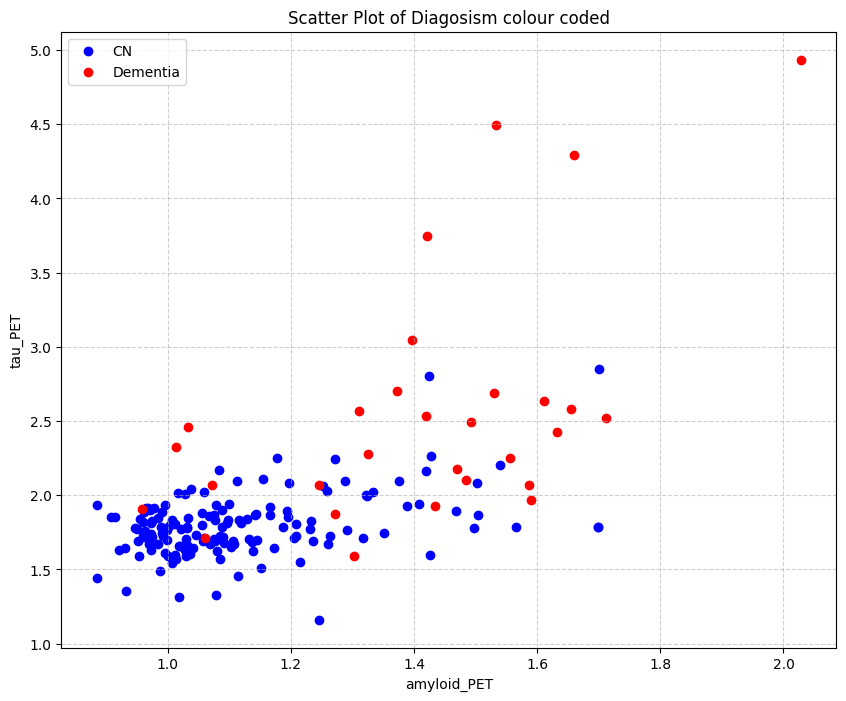

In [637]:
# Scatterplot of PET values for each group, over the 2 features as the x and y axes

plt.figure(figsize=(10, 8))

dem_neg = dem_train[dem_train['DX'] == 'CN']
dem_pos = dem_train[dem_train['DX'] == 'Dementia']

plt.scatter(dem_neg['amyloid_PET'], dem_neg['tau_PET'], color='blue', label='CN')
plt.scatter(dem_pos['amyloid_PET'], dem_pos['tau_PET'], color='red', label='Dementia')

plt.title('Scatter Plot of Diagosism colour coded')
plt.xlabel('amyloid_PET')
plt.ylabel('tau_PET')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [638]:
linear_model = LinearRegression()

features = ['amyloid_PET', 'tau_PET']
label = 'Dbin'

linear_model.fit(dem_train[features], dem_train[label])

print(linear_model.coef_)
print(linear_model.intercept_)

[0.42816944 0.34853678]
-1.008734265520877


### Calculate decision boundary

The boundary would be given by this formula: 0 = b1x1 + b2x2 + c

=> b2x2 = -b1x1 - c + 0.5

=> x2 = (-b1/b2)x1 + (0.5 - c) / b2

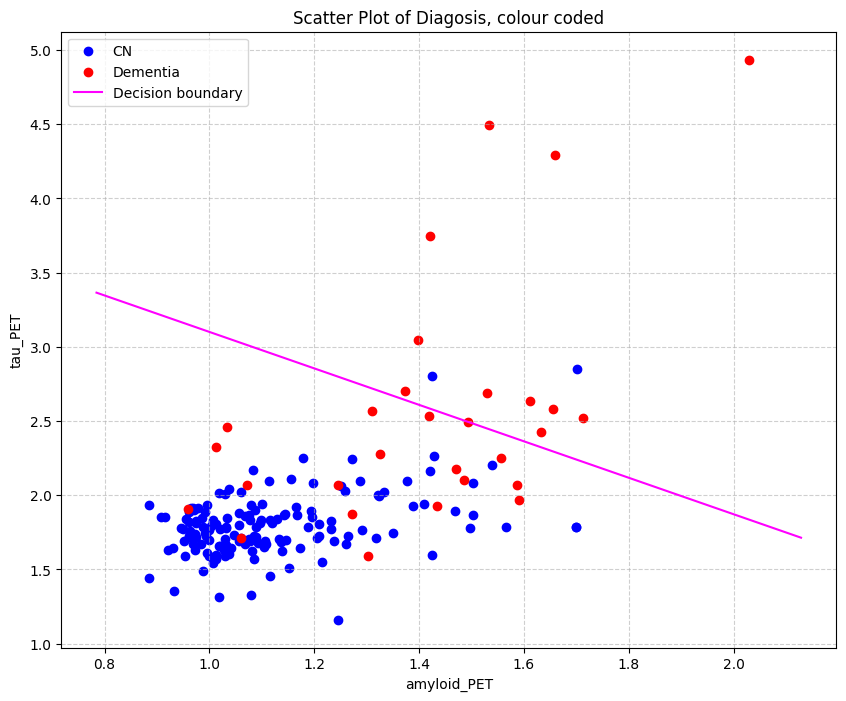

In [639]:
b1 = linear_model.coef_[0]
b2 = linear_model.coef_[1]
intercept = linear_model.intercept_

grad = (-b1/b2)
y_intercept = (0.5 - intercept) / b2

# Add to graph for a general range of values
x_min = dem_train['amyloid_PET'].min() - 0.1
x_max = dem_train['amyloid_PET'].max() + 0.1
x_range = np.linspace(x_min, x_max, 100)
y_boundary = x_range * grad + y_intercept

plt.figure(figsize=(10, 8))

dem_neg = dem_train[dem_train['DX'] == 'CN']
dem_pos = dem_train[dem_train['DX'] == 'Dementia']

plt.scatter(dem_neg['amyloid_PET'], dem_neg['tau_PET'], color='blue', label='CN')
plt.scatter(dem_pos['amyloid_PET'], dem_pos['tau_PET'], color='red', label='Dementia')
plt.plot(x_range, y_boundary, color='magenta', linestyle='-', label='Decision boundary')

plt.title('Scatter Plot of Diagosis, colour coded')
plt.xlabel('amyloid_PET')
plt.ylabel('tau_PET')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [640]:
# Calculate metrics of boundary on test set

dem_test['linear_pred'] = linear_model.predict(dem_test[['amyloid_PET', 'tau_PET']])
dem_test['bin_pred'] = (dem_test['linear_pred'] > 0.5).astype(int)

In [641]:
calculate_metrics(dem_test, 'bin_pred')

bin_pred
{'TN': np.int64(120), 'TP': np.int64(19), 'FN': np.int64(12), 'FP': np.int64(4)}
Sensitivity: 0.6129032258064516
Specificity: 0.967741935483871
Accuracy: 0.896774193548387


## (c) Multimodal Boundary

In [642]:
# Back to full datasets

dem_train = pd.read_csv('./Dementia_train.csv')
dem_test = pd.read_csv('./Dementia_test.csv')

dem_train.dropna(inplace=True)
dem_test.dropna(inplace=True)

# Encode Dementia label specifically as either 0 or 1

dem_train['Dbin'] = (dem_train['DX'] == 'Dementia').astype(int)
dem_test['Dbin'] = (dem_test['DX'] == 'Dementia').astype(int)

In [643]:
# EDA

dem_train['DX'].value_counts()

DX
CN          149
MCI          73
Dementia     29
Name: count, dtype: int64

In [644]:
# Find mean for different diagnosis cases

cn_cases = dem_train[dem_train['DX'] == 'CN'][['amyloid_PET', 'tau_PET']]
mci_cases = dem_train[dem_train['DX'] == 'MCI'][['amyloid_PET', 'tau_PET']]
dem_cases = dem_train[dem_train['DX'] == 'Dementia'][['amyloid_PET', 'tau_PET']]

cn_means = cn_cases.mean()
mci_means = mci_cases.mean()
dem_means = dem_cases.mean()

# Find overall covariance matrix (a simplifying assumping of LDA)

cov = dem_train[['amyloid_PET', 'tau_PET']].cov()

print(cn_means)
print(mci_means)
print(dem_means)
print(cov)

amyloid_PET    1.120797
tau_PET        1.799892
dtype: float64
amyloid_PET    1.164474
tau_PET        2.089793
dtype: float64
amyloid_PET    1.420028
tau_PET        2.567052
dtype: float64
             amyloid_PET   tau_PET
amyloid_PET     0.048079  0.059001
tau_PET         0.059001  0.261513


### Formula for LDA decision boundary between two classes with equal priors: 

(- 0.5) * (m1 - m2).T * cov_inv * (m1 + m2) + x.T * cov_inv * (m1 - m2) = 0

In [645]:
x_min = dem_train['amyloid_PET'].min() - 0.1
x_max = dem_train['amyloid_PET'].max() + 0.1
x_range = np.linspace(x_min, x_max, 100)

Cov_inv = np.linalg.inv(cov.values)

In [646]:
# Between CN and Dementia

mu1 = cn_means.values
mu2 = dem_means.values

m = 0.5 * (cn_means + dem_means)
w = Cov_inv.dot(mu1 - mu2)
c = (0.5) * (mu1 - mu2).dot(Cov_inv.dot(mu1 + mu2))
y_cn_dem = (c - w[0] * x_range) / w[1]

In [647]:
# Between CN and MCI

mu1 = cn_means.values
mu2 = mci_means.values

m = 0.5 * (cn_means + mci_means)
w = Cov_inv.dot(mu1 - mu2)
c = (0.5) * (mu1 - mu2).dot(Cov_inv.dot(mu1 + mu2))
y_cn_mci = (c - w[0] * x_range) / w[1]

In [648]:
# Between MCI and Dementia

mu1 = mci_means.values
mu2 = dem_means.values

m = 0.5 * (mci_means + dem_means)
w = Cov_inv.dot(mu1 - mu2)
c = (0.5) * (mu1 - mu2).dot(Cov_inv.dot(mu1 + mu2))
y_mci_dem = (c - w[0] * x_range) / w[1]

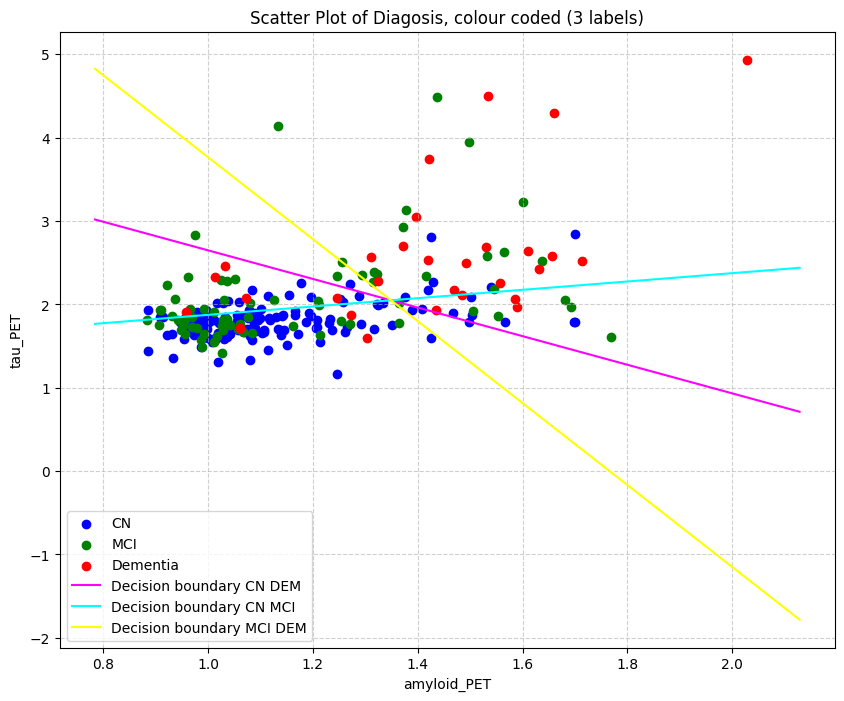

In [649]:
y_boundary = x_range * grad + y_intercept

plt.figure(figsize=(10, 8))

plt.scatter(cn_cases['amyloid_PET'], cn_cases['tau_PET'], color='blue', label='CN')
plt.scatter(mci_cases['amyloid_PET'], mci_cases['tau_PET'], color='green', label='MCI')
plt.scatter(dem_cases['amyloid_PET'], dem_cases['tau_PET'], color='red', label='Dementia')

# Add boundaries

plt.plot(x_range, y_cn_dem, color='magenta', linestyle='-', label='Decision boundary CN DEM')
plt.plot(x_range, y_cn_mci, color='cyan', linestyle='-', label='Decision boundary CN MCI')
plt.plot(x_range, y_mci_dem, color='yellow', linestyle='-', label='Decision boundary MCI DEM')

plt.title('Scatter Plot of Diagosis, colour coded (3 labels)')
plt.xlabel('amyloid_PET')
plt.ylabel('tau_PET')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [650]:
# Remake CN DEM boundary

mu1 = cn_means.values
mu2 = dem_means.values

m = 0.5 * (cn_means + dem_means)
w = Cov_inv.dot(mu1 - mu2)
c = (0.5) * (mu1 - mu2).dot(Cov_inv.dot(mu1 + mu2))

# Apply boundary to each test data point

dem_test['boundary_pos'] = ((c - w[0] * dem_test['amyloid_PET']) / w[1])

# Predict Dementia or CN, based off of whether the tau value of each test point is higher than the boundary, for it's x value i.e. amyload_PET value. 
# This would put a particular point above the boundary, which is the region that corresponds to Dementia. Dementia gets a bin_pred2 value of 1.

dem_test['bin_pred2'] = (dem_test['tau_PET'] > dem_test['boundary_pos']).astype(int)

In [651]:
calculate_metrics(dem_test, 'bin_pred2')

bin_pred2
{'TN': np.int64(173), 'FP': np.int64(44), 'TP': np.int64(24), 'FN': np.int64(7)}
Sensitivity: 0.7741935483870968
Specificity: 0.7972350230414746
Accuracy: 0.7943548387096774


# Exercise 2: Gradient Descent

## (a) Rosenblatt Perceptron

In [652]:
a = [1, -1, 1]
b = [-1, -1, 1]

c = [(x, y) for x, y in zip(a, b) if x * y < 0]

print(c)

[(1, -1)]


In [653]:
#implement rosenblatt's perceptron for a 2D example
#Y are the target labels (-1,1)
#X is the input data
#rho is the learning rate
#max_iter controls the maximum number of iterations
##Note: both, rho and max_iter can be left to their default values

#function returns the intercept_ (\beta_0) and the coefficients_ (\beta_i)
def rosen_perceptron(Y, X, rho=0.1, max_iter = 1000):
  #initialize with random parameters
  intercept_ = np.random.randn()
  #as many coefficients as there are columns (features) in X
  coef_ = np.random.randn(X.shape[1])

  #make predictions
  Y_hat = intercept_ + np.dot(X, coef_)

  #compute the list of misclassified samples and store in M
  ########## complete here

  # y_hat counts as a misclassification if it is negative while y is positive or vice versa
  # or equivalently if y * y_hat is negative

  M = [(x, y, yh) for x, y, yh in zip(X, Y, Y_hat) if y * yh < 0]
  ##########

  iter = 0
  #as long as there are misclassified samples in M and we have not reached the
  #maximal number of interations continue to update coefficients etc.
  while len(M) > 0 and iter < max_iter:

    #make gradient step (update intercept and coefficients)
    ########## complete here

    # Update using stochastic gradient descent (using one value of M at a time to update weights)
    for x, y, _ in M:
      intercept_  = intercept_ + rho * y
      coef_       = coef_ + rho * x * y
    ##########

    #make predictions using new parameters
    Y_hat = intercept_ + np.dot(X, coef_)

    ##update the list of misclassified samples and store in M
    ########## complete here
    M = [(x, y, yh) for x, y, yh in zip(X, Y, Y_hat) if y * yh < 0]
    ##########

    iter += 1

  return intercept_, coef_

In [654]:
sim_data = pd.read_csv("./sim_data.csv")

# EDA

print(sim_data.head())
print(sim_data.info())
print(sim_data.describe())

   Unnamed: 0        X1        X2    Y
0           0  0.709628  1.580241  1.0
1           1  2.048487 -0.508790  1.0
2           2 -1.875315 -0.584728  1.0
3           3  0.368092 -1.362961  1.0
4           4 -1.353616  0.486189  1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  100 non-null    int64  
 1   X1          100 non-null    float64
 2   X2          100 non-null    float64
 3   Y           100 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 3.3 KB
None
       Unnamed: 0          X1          X2           Y
count  100.000000  100.000000  100.000000  100.000000
mean    49.500000    2.004750    1.979087    0.000000
std     29.011492    2.465733    2.428778    1.005038
min      0.000000   -2.272043   -2.610904   -1.000000
25%     24.750000   -0.063315    0.026460   -1.000000
50%     49.500000    2.000290    1.904

In [655]:
X = np.array(sim_data[['X1', 'X2']])
Y = np.array(sim_data[['Y']])

In [656]:
intercepts = []
coeffs = []

for i in range(5):
    intercept, coeff = rosen_perceptron(Y, X)
    print(intercept)
    print(coeff)
    intercepts.append(intercept)
    coeffs.append(coeff)

[16.55390078]
[-6.65138691 -7.25555662]
[11.90003517]
[-4.59664128 -5.29898417]
[16.80867151]
[-6.64178077 -7.48213622]
[3.52772837]
[-1.03761926 -1.04188719]
[10.93784913]
[-4.26698933 -4.83706454]


### The boundary is where b1x1 + b2x2 + beta = 0, therefore it's where x2 = (-b1x1 -beta) / b2

100


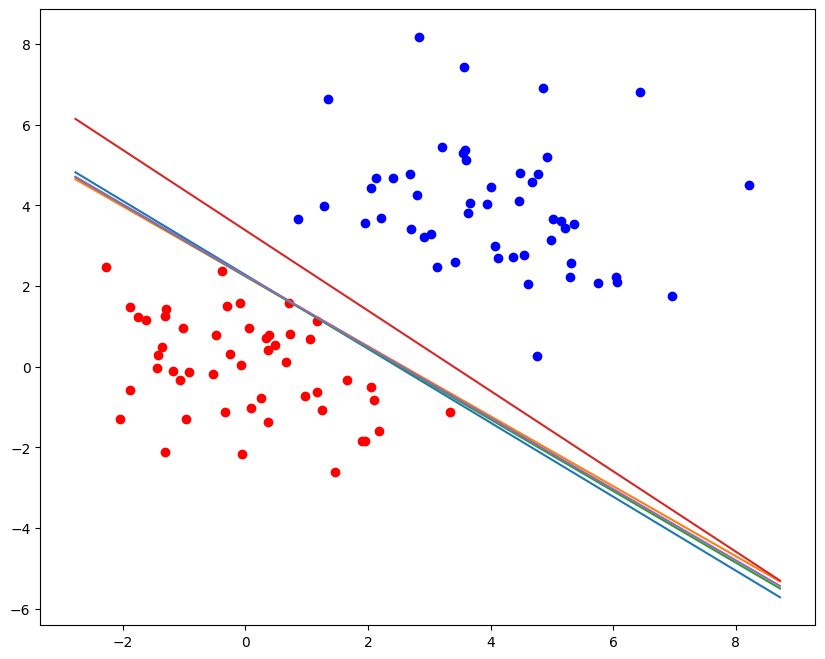

In [657]:
sim_data_pos = sim_data[sim_data['Y'] == 1]
sim_data_neg = sim_data[sim_data['Y'] == -1]

print(len(sim_data_neg) + len(sim_data_pos))

plt.figure(figsize=(10, 8))
plt.scatter(sim_data_pos['X1'], sim_data_pos['X2'], color='red')
plt.scatter(sim_data_neg['X1'], sim_data_neg['X2'], color='blue')

x_min = sim_data['X1'].min() - 0.5
x_max = sim_data['X1'].max() + 0.5

x_range = np.linspace(x_min, x_max, 100)

for i in range(5):
    intercept = intercepts[i]
    coeff = coeffs[i]

    boundary_y = (-coeff[0] * x_range - intercept) / coeff[1]

    plt.plot(x_range, boundary_y, linestyle='-', label=f'Decision boundary {i}')


## (b) Logistic Regression with Gradient Descent

## Cost function and gradient

### Cost function
$$J(\beta) = - \frac{1}{m} \sum_{i=1}^{m} [ y_i \cdot \log(p(x_i;\beta)) + (1 - y_i) \cdot \log(1 - p(x_i;\beta)) ] = - \frac{1}{m} \sum_{i=1}^{N} \{ y_i \beta^T x_i - \log(1 + \exp(\beta^T x_i)) \}$$

### This is equal to -1/m times the log likehood (included 1/m to get the average cost per data point, where m is the number of datapoints. Included - to turn the log likelihood into a cost function)

### Gradient:
$$\frac{\delta J(\beta)}{\delta \beta} = - \frac{1}{m} \sum_{i=1}^{N} x_i(y_i - p(x_i; \beta)) = - \frac{1}{m} X^{T}(y - p)$$

In [658]:
import numpy as np
from scipy.special import expit

In [659]:
class LogRegGrad:
  def __init__(self, niter = 1000):
    #beta coefficients to be trained
    self._betas = None
    #other useful parameteres
    self._N = None
    self._p = None
    #number of iterations
    self._max_iter = niter
    #default learning rate
    self._alpha = 0.001

    self._loss = []

  def _sigmoid(self, value):
    return expit(value)

  #predicts class probabilities
  def predict(self, X):
    prob1 = self._sigmoid( X @ self._betas)
    prob0 = 1.0 - prob1
    #make both probs 'stable'
    prob1[prob1 == 0.0] = 10**-10
    prob0[prob0 == 0.0] = 10**-10
    return prob0, prob1

  def predictNew(self, X):
    N = X.shape[0]
    tmpX = np.c_[np.ones(self._N),X]
    return self.predict(tmpX)

  #computes the cost, add function parameters as required
  def _compute_cost(self, y, prob0, prob1):
    ###
    # The Log loss cost function would be the negative of the log-likelihood
    # Take the mean cost
    my_cost = - np.mean(y @ np.log(prob1) + (1 - y) @ np.log(prob0))
    ###

    #log the cost history
    self._loss.append(my_cost)
    return my_cost

  #computes the gradient, add function parameteres as required
  def _compute_gradient(self, X, y, prob1):
    ###
    # Take "mean" gradient
    grad = (-1 / self._N) * (X.T @ (y - prob1))
    ###
    return grad

  #fit function
  # y is the target
  # features is the feature matrix (i.e., X)
  # alpha is the learning rate
  def fit(self, y, features, alpha=0.1):

    # Format data to numpy array
    if not isinstance(y, np.ndarray):
      y = np.array(y)
      
    if not isinstance(features, np.ndarray):
      features = np.array(features)

    self._alpha = alpha
    #sample size
    self._N = features.shape[0]
    #feature dim
    self._p = features.shape[1] + 1
    #initalize beta with 0s
    self._betas = np.zeros(self._p)
    #add column of 1 to X
    X = np.c_[np.ones(self._N),features]

    #compute predictions for class 1 and 2
    prob0, prob1 = self.predict(X)

    ######################## complete here
    cost = self._compute_cost(y, prob0, prob1)
    ########################
    self._loss = []
    niter = 0
    while niter < self._max_iter:
        #beta update
        ######################## complete here
        grad = self._compute_gradient(X, y, prob1)
        self._betas -= grad * self._alpha
        ########################
        prob0, prob1 = self.predict(X)
        #recompute cost
        ####################### complete here
        cost = self._compute_cost(y, prob0, prob1)
        #######################
        niter += 1

In [660]:
pd_data = pd.read_csv('PD_data.csv')
print(pd_data['Unnamed: 0'])

0        0
1        1
2        2
3        3
4        4
      ... 
202    202
203    203
204    204
205    205
206    206
Name: Unnamed: 0, Length: 207, dtype: int64


In [661]:
pd_data = pd.read_csv('PD_data.csv')

# EDA

# Remove first column since it only contains indexes
pd_data = pd_data.drop(columns="Unnamed: 0")

print(pd_data.info())
#No NA values, no need to dropna
print(pd_data.describe())
print(pd_data['DX'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 85 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   LLatVent                           207 non-null    float64
 1   RLatVent                           207 non-null    float64
 2   Lthal                              207 non-null    float64
 3   Rthal                              207 non-null    float64
 4   Lcaud                              207 non-null    float64
 5   Rcaud                              207 non-null    float64
 6   Lput                               207 non-null    float64
 7   Rput                               207 non-null    float64
 8   Lpal                               207 non-null    float64
 9   Rpal                               207 non-null    float64
 10  Lhippo                             207 non-null    float64
 11  Rhippo                             207 non-null    float64

None
           LLatVent      RLatVent         Lthal         Rthal         Lcaud  \
count  2.070000e+02  2.070000e+02  2.070000e+02  2.070000e+02  2.070000e+02   
mean  -1.544658e-16  2.660245e-16 -1.032990e-15  1.194965e-15 -1.085551e-15   
std    1.002424e+00  1.002424e+00  1.002424e+00  1.002424e+00  1.002424e+00   
min   -1.728293e+00 -1.560906e+00 -2.476377e+00 -2.737937e+00 -2.092641e+00   
25%   -6.548816e-01 -6.415591e-01 -7.321135e-01 -7.100354e-01 -7.724460e-01   
50%   -2.516746e-01 -2.331221e-01 -9.721318e-02 -5.235974e-02 -7.323406e-02   
75%    3.616754e-01  3.428836e-01  7.001317e-01  6.537446e-01  6.668790e-01   
max    4.179884e+00  4.451478e+00  2.835920e+00  2.704922e+00  2.590497e+00   

              Rcaud          Lput          Rput          Lpal          Rpal  \
count  2.070000e+02  2.070000e+02  2.070000e+02  2.070000e+02  2.070000e+02   
mean   1.866462e-15 -8.710156e-16 -1.132749e-15 -1.862171e-15  2.831873e-16   
std    1.002424e+00  1.002424e+00  1.002424e+0

In [662]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features to improve the gradient descent algorithms
min_max_scaler = MinMaxScaler()

features = np.array(pd_data.iloc[:, :-1])
labels = np.array(pd_data.iloc[:, -1])

min_max_scaler.fit_transform(features)
features = min_max_scaler.transform(features)

In [663]:
from sklearn.linear_model import LogisticRegression

model_sk = LogisticRegression()

model_sk.fit(features, labels)

all_coef_sk = [model_sk.intercept_[0]] + list(model_sk.coef_[0])

In [664]:
model_custom = LogRegGrad(niter=3000)

model_custom.fit(labels, features, alpha=0.1)

In [665]:
model_custom._betas

array([ 1.00937207,  0.4080549 ,  1.90675431,  1.99749321, -0.12283129,
        0.61363557,  0.85032238, -0.42523856, -0.36171763,  0.41037426,
        0.28925697,  0.67052186,  0.07285811,  0.93850218,  0.55252539,
        0.13055866, -0.22787057,  0.80693051,  0.59997023,  1.17161993,
        0.38543267,  0.8369217 ,  1.62379846, -0.45047275, -0.53141119,
        1.29597942, -0.61250955, -0.67097105,  0.196971  ,  0.01912905,
       -0.79039905,  0.56198874,  1.13760747,  0.88777385,  0.82125175,
       -0.81195332, -0.08696701,  0.24856337,  0.77490733, -1.77855969,
       -0.67423153,  0.07366824, -0.75528923, -0.29521028,  0.01305441,
        0.10519051, -0.57414316, -0.15884368, -0.46136549, -0.14963733,
       -0.36365434,  0.4760021 ,  0.67361147, -0.33278847, -1.26406518,
       -1.29217158, -0.81817454,  0.713787  , -1.05764453, -0.72997175,
       -0.34509862, -0.6206295 , -0.17973239,  0.49247487, -0.90984508,
       -0.7371066 , -0.51430548, -0.17221261,  0.25433502,  0.17

Text(0, 0.5, "Sk learn model's coeffs")

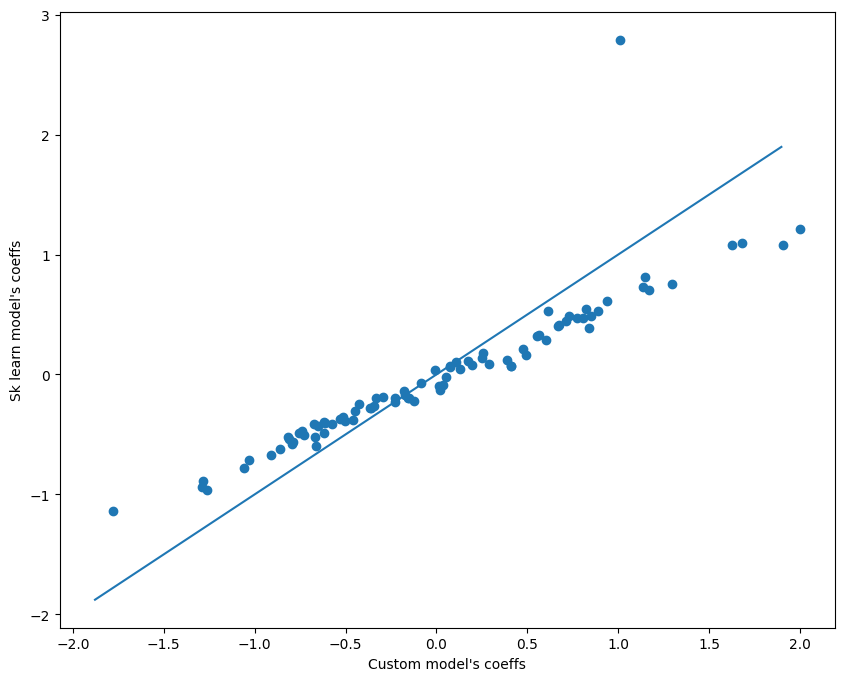

In [666]:
plt.figure(figsize=(10, 8))

all_features = list(pd_data.columns[:-1]) + ["intercept"]

x_min = model_custom._betas.min() - 0.1
x_max = model_custom._betas.max() - 0.1
x_range = np.linspace(x_min, x_max, 1000)

plt.scatter(model_custom._betas, all_coef_sk)
plt.plot(x_range, x_range)
plt.xlabel("Custom model's coeffs")
plt.ylabel("Sk learn model's coeffs")

### Coeffs look very similar for most features, but not the same. I notice that larger coefficients which appear in my custom model, appear to be smaller in the Sklearn model (with 1 outlier). This could be due to the LogisticRegression from sklearn having an l2 regularizer built in by default, which would prevent certain coefficients from growing too large.

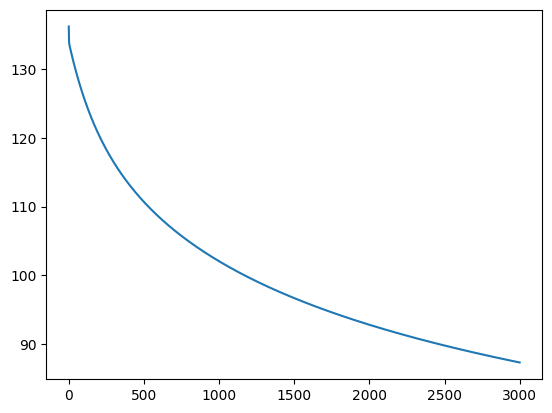

In [667]:
# Check cost over training

plt.plot(model_custom._loss)

## (C) Hinge Loss and L1 regularization with gradient descent

## Cost function and gradient

### Cost function
$J(\beta) = \left[ \frac{1}{N} \sum_{i=1}^{N} \max(0, 1 - y_i(\beta_0 + \beta^\top x_i)) \right] + \lambda \sum_{j=1}^{p} |\beta_j|$

### Where p is the number of features, and N the number of datapoints

### Gradient:
$\frac{\delta J(\beta)}{\delta \beta} = \left( \frac{1}{N} \sum_{i=1}^{N} \begin{cases} -y_i x_i & \text{if } y_i(\beta_0 + \beta^\top x_i) < 1 \\ 0 & \text{if } y_i(\beta_0 + \beta^\top x_i) \ge 1 \end{cases} \right) + \lambda  \text{sign}(\beta_j)$

### Where we assume that x0 is equal to one, in order to get beta0's gradient

In [668]:
class HingeL1Grad:
  def __init__(self, niter = 1000):
    #beta coefficients to be trained
    self._betas = None
    #other useful parameteres
    self._N = None
    self._p = None
    #number of iterations
    self._max_iter = niter
    #default learning rate
    self._alpha = 0.001

    self._loss = []

  #predicts class probabilities
  def predict(self, X):
    yhat = X @ self._betas
    return yhat

  def predictNew(self, X):
    N = X.shape[0]
    tmpX = np.c_[np.ones(self._N),X]
    return self.predict(tmpX)

  #computes the cost, add function parameteres as needed
  def _compute_cost(self, X, y, yhat, lam):
    #compute the cost
    ######
    reg_cost = lam * np.sum(np.abs(self._betas))
    mean_hinge_cost = np.sum(np.maximum(1 - (y * yhat), np.zeros(self._N)))
    my_cost = (mean_hinge_cost + reg_cost) / self._N
    ######

    #log the cost history
    self._loss.append(my_cost)
    return my_cost

  #computes the gradient, add function parameters as needed
  def _compute_gradient(self, X, y, yhat, lam):
    #########
    output = y.copy()
    zero_mask = (y * yhat) >= 1
    output[zero_mask] = 0
    hinge_grad = -output @ X
    reg_grad = lam * np.sign(self._betas)
    grad = hinge_grad + reg_grad
    #########
    # Choosing to take the mean of both the hinge part of the loss, and the regularizing part.
    return grad / self._N

  #fit function
  # y is the target
  # features is the feature matrix (i.e., X)
  # lam is the regularization strength (lambda)
  # alpha is the learning rate
  def fit(self, y, features, lam=0, alpha=0.001):
    self._alpha = alpha
    #sample size
    self._N = features.shape[0]
    #feature dim
    self._p = features.shape[1] + 1
    #initalize beta with 0s
    self._betas = np.zeros(self._p)
    #add column of 1 to X
    X = np.c_[np.ones(self._N),features]

    #compute predictions for class 1 and 2
    yhat = self.predict(X)

    ########### complete here
    cost = self._compute_cost(X, y, yhat, lam)
    ###########
    self._loss = []
    niter = 0

    while niter < self._max_iter:
        niter += 1
        #beta update
        ######################## complete here
        grad = self._compute_gradient(X, y, yhat, lam)
        self._betas -= grad * self._alpha
        ########################
        yhat = self.predict(X)
        ####################### complete here
        cost = self._compute_cost(X, y, yhat, lam)
        #######################

In [669]:
# Use same features and labels as 2b, but make 0 labels into -1

labels[labels == 0] = -1

print(labels[:10])

model_custom = HingeL1Grad(niter=3000)

model_custom.fit(labels, features, lam=5, alpha=0.001)

[ 1  1 -1  1  1  1  1 -1 -1  1]


Text(0, 0.5, "Sk learn model's coeffs")

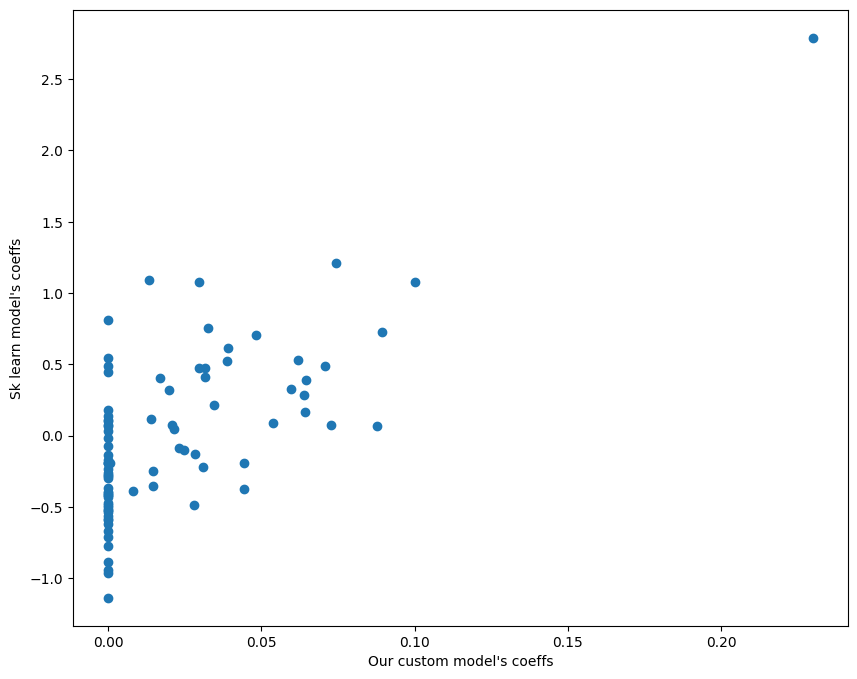

In [670]:
plt.figure(figsize=(10, 8))

all_features = list(pd_data.columns[:-1]) + ["intercept"]

plt.scatter(model_custom._betas, all_coef_sk)
plt.xlabel("Our custom model's coeffs")
plt.ylabel("Sk learn model's coeffs")

### Our model has a lot of zero betas which aren't zero in the sklearn LR model. This is caused by the strong L1 regularization

## (d) ADAM
Copy either your solution ffrom (b) or (c) and modify the fit function to implement ADAM (momentum + RMSprop) as introduced in the lectures

In [671]:
class HingeL1GradAdam:
  def __init__(self, niter = 1000):
    #beta coefficients to be trained
    self._betas = None
    #other useful parameteres
    self._N = None
    self._p = None
    #number of iterations
    self._max_iter = niter
    #default learning rate
    self._alpha = 0.001

    #Momentum constant, using popular choice
    self._gamma1 = 0.9

    #RMS prop constants, using popular choice
    self._gamma2 = 0.999
    self._eps = 1e-8

    #m momentum
    self.m = 0

    #s second momentum
    self.s = 0

    self._loss = []

  #predicts class probabilities
  def predict(self, X):
    yhat = X @ self._betas
    return yhat

  def predictNew(self, X):
    N = X.shape[0]
    tmpX = np.c_[np.ones(self._N),X]
    return self.predict(tmpX)

  #computes the cost, add function parameteres as needed
  def _compute_cost(self, X, y, yhat, lam):
    #compute the cost
    ######
    reg_cost = lam * np.sum(np.abs(self._betas))
    mean_hinge_cost = np.sum(np.maximum(1 - (y * yhat), np.zeros(self._N)))
    my_cost = (mean_hinge_cost + reg_cost) / self._N
    ######

    #log the cost history
    self._loss.append(my_cost)
    return my_cost

  #computes the gradient, add function parameters as needed
  def _compute_gradient(self, X, y, yhat, lam):
    #########
    output = y.copy()
    zero_mask = (y * yhat) >= 1
    output[zero_mask] = 0
    hinge_grad = -output @ X
    reg_grad = lam * np.sign(self._betas)
    grad = hinge_grad + reg_grad
    #########
    # Choosing to take the mean of both the hinge part of the loss, and the regularizing part.
    return grad / self._N


  #fit function
  # y is the target
  # features is the feature matrix (i.e., X)
  # lam is the regularization strength (lambda)
  # alpha is the learning rate
  def fit(self, y, features, lam=0, alpha=0.001):
    self._alpha = alpha
    #sample size
    self._N = features.shape[0]
    #feature dim
    self._p = features.shape[1] + 1
    #initalize beta with 0s
    self._betas = np.zeros(self._p)
    #add column of 1 to X
    X = np.c_[np.ones(self._N),features]

    #compute predictions for class 1 and 2
    yhat = self.predict(X)

    ########### complete here
    cost = self._compute_cost(X, y, yhat, lam)
    ###########
    self._loss = []
    niter = 0

    while niter < self._max_iter:
        niter += 1
        #beta update
        ######################## complete here
        grad = self._compute_gradient(X, y, yhat, lam)

        # Implement ADAM
        self.m = self._gamma1 * self.m + (1 - self._gamma1) * grad

        self.s = self._gamma2 * self.s + (1 - self._gamma2) * grad**2

        # Correct bias in estimates
        m_cor = self.m / (1 - self._gamma1**niter)
        s_cor = self.s / (1 - self._gamma2**niter)

        adam_update = -self._alpha * m_cor / (np.sqrt(s_cor) + self._eps)
        
        self._betas += adam_update
        ########################
        yhat = self.predict(X)
        ####################### complete here
        cost = self._compute_cost(X, y, yhat, lam)
        #######################

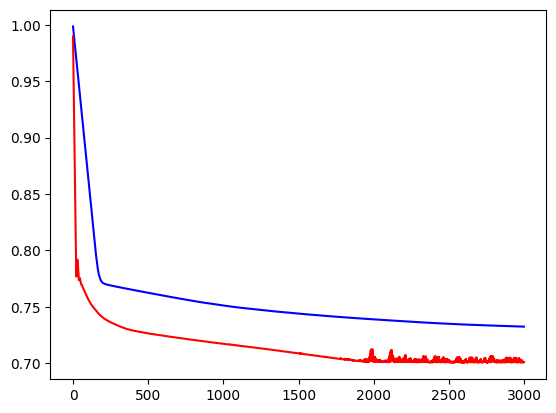

In [672]:
model_custom_adam = HingeL1GradAdam(niter=3000)

model_custom_adam.fit(labels, features, lam=5, alpha=0.001)

plt.plot(model_custom._loss, color='blue', )
plt.plot(model_custom_adam._loss, color='red')

### We can see that the ADAM model converges much more quickly than the first model... it ends up at a lower overall cost as well after 3000 itereations, converging downwards much more quickly. This is because the combination of Momentum and RMSProp in Adam make the gradient descent much quicker

# Exercise 3: Hippocampus segmentation


In [ ]:
#useful to unzip the data when working on Colab
import zipfile
unzip_data = True

if unzip_data:
  with zipfile.ZipFile("./hippocampus.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [ ]:
import numpy as np
import sklearn
import nibabel as nib
import matplotlib.pyplot as plt
import skimage
import sys
from scipy import ndimage
from os import listdir
from os.path import isfile, join
import time
import pandas as pd
import gc

In [ ]:
data_path = './'
train_path= data_path + "imagesTr/"
test_path= data_path + "imagesTest/"
vali_path= data_path + "imagesVali/"

labels_train = data_path + "labelsTr/"
labels_test = data_path + "labelsTest/"
labels_vali = data_path + "labelsVali/"


In [ ]:
#displays three slices of the 3D volume at the specified x, y, z values
#over: provide an ndarray that is treated as an overlay
#overcut: specify a cutoff value for the overlay, smaller values will not be displayed
def displayNii(dat, x=18, y=29, z=18, over=None, overcut = 0.0, mycmap="gray"):
  fig, axs = plt.subplots(1, 3, figsize=(6, 10), gridspec_kw={'width_ratios': [2, 1.5, 1]})

  idx = None
  axs[0].imshow(dat[x,:,::-1].T, cmap=mycmap)
  axs[1].imshow(dat[::-1,y,::-1].T, cmap=mycmap)
  axs[2].imshow(dat[::-1,::-1,z].T, cmap=mycmap)

  axs[0].set_title('x=' + str(x))
  axs[1].set_title('y=' + str(y))
  axs[2].set_title('z=' + str(z))

  if over is not None:
    idx = over.copy()
    idx[idx <= overcut] = None
    axs[0].imshow(idx[x,:,::-1].T, alpha=0.5)
    axs[1].imshow(idx[::-1,y,::-1].T, alpha=0.5)
    axs[2].imshow(idx[::-1,::-1,z].T, alpha=0.5)

  axs[0].axis('off')
  axs[1].axis('off')
  axs[2].axis('off')
  plt.show()

In [ ]:
#load the image along with the segmentation mask of subject with id 'id'
def load_image(id, img_folder, lab_folder):
  img = nib.load(img_folder + "hippocampus_" + id + ".nii.gz")
  lab = nib.load(lab_folder + "hippocampus_" + id + ".nii.gz")

  data_raw = img.get_fdata()
  #do a min-max normalization of the entire image
  A = np.min(data_raw)
  B = np.max(data_raw)
  data_norm = (data_raw - A) / (B - A) * 1000

  #all pixles labeled 1 or 2 are part of the hippocampus
  data_lab = (lab.get_fdata() > 0) * 1.0

  return data_norm, data_lab

In [ ]:
#compute a range of fliteres as additional channels
def preprocess_img(dat, only_dim=False):
  #copy original image
  res = dat.copy()
  #apply sobel filter
  sob = ndimage.sobel(dat)
  #apply gaussian filter with \sigma=1
  gau = ndimage.gaussian_filter(dat, sigma=1)
  #apply gaussian filter with \sigma=2
  gau2 = ndimage.gaussian_filter(dat, sigma=2)
  #concatenate original image with
  tmp = [ res, sob, gau2 - gau ]
  res = np.stack( tmp, 3)
  if only_dim:
    return(res.shape[3])
  return(res)

In [ ]:
#extracts a feature vectors from a given image with id 'imgid'
#the dimension of the cube is pdim x pdim x pdim
#of all possible cubes in the image ony a random fraction of 'sfreq' is returned
def extractFeatures(imgid, img_folder, lab_folder, pdim=3, sfreq=0.01, verbose=False):

  #load raw image
  dat_norm, lab = load_image(imgid, img_folder, lab_folder)

  #compute extra channels
  dat = preprocess_img(dat_norm)

  #add dimension to lab if needed (in case we have >1 channel in dat)
  if len(dat.shape) > 3:
    lab = np.expand_dims(lab, 3)
    tmp = np.concatenate( [dat, lab], axis=3)
  else:
    tmp = np.stack((dat, lab),3)

  #total channels
  xdim = tmp.shape[3]

  #make all possible patches/cubes
  patches = skimage.util.shape.view_as_windows(tmp, (pdim,pdim,pdim,xdim))

  if verbose:
    print (patches.shape)

  #sample patches randomly with frequency sfreq
  #e.g., sfreq=0.01 will sample 1% of all patches/cubes
  mysample = np.random.choice(2, size=patches.shape[:3], replace=True, p=[1-sfreq, sfreq]) == 1

  #midpoint of the cube
  midp = int((pdim - 1)/2)

  #central pixel
  labels   = patches[mysample][:,0,midp,midp,midp,xdim-1]
  features = patches[mysample][:,0,:,:,:,:(xdim-1)]
  #flatten each feature vector
  features_flat = features.reshape(features.shape[0], pdim*pdim*pdim*(xdim-1))

  return labels, features_flat

In [ ]:
#extracts a feature vectors from all images in a given folder
#the dimension of the cube is pdim x pdim x pdim
#of all possible cubes in the image ony a random fraction of 'sample_freq' is returned
def create_training_set(img_folder, lab_folder, pdim=5, sample_freq=0.01, verbose=False):
  Y = []
  sample_id = []

  #get list of all files in img_folder:
  my_files = [f for f in listdir(img_folder) if isfile(join(img_folder, f))]
  my_files_short = [f.replace("hippocampus_","").replace(".nii.gz","") for f in my_files]
  my_files_short.sort()

  #load first image to estimate number of channels
  dat, _ = load_image(my_files_short[0], img_folder, lab_folder)
  fdim = preprocess_img(dat, only_dim=True)

  print("Extracting cubes of size " + str(pdim) + "^3 and " + str(fdim) + " channels. Sampling with frequency " + str(sample_freq) + " from each image.")

  #create the feature matrix
  X = np.empty((0,pdim**3*fdim))
  for id in my_files_short:
    if versbose:
      sys.stdout.write("working on Image ID: " + id + "\n")
    #extract the labels and the flat feature vecotr from all extracted patches
    labels, features = extractFeatures(id, img_folder, lab_folder, pdim, sfreq=sample_freq, verbose=False)
    #keep track of the matchin labels
    Y.extend(labels)
    #keep track from which image the samples were taken
    sample_id.extend([id] * len(labels))
    #append the features extracted from of sampled cubse of the image to the training data
    X = np.concatenate((X, features), axis=0)
  Y = np.array(Y)
  return Y, X, sample_id


In [ ]:
#this function takes X and Y as input and
#oversamples the target class ('1') with a ratio:1 ratio (default: None)
# if ratio is None, then it will be set to 1/f, where f is the frequency
# of the target class
#from the overall size of X a sub_sample of 'sample_size' is randomly selected
def sub_sample(X, Y, sample_size=10000, ratio=None):
    #compute class 1 frequency
    rtclass = np.sum(Y)/len(Y)
    if ratio is None:
        ratio = 1.0/rtclass
        print("sampling with ratio 1:" + str(ratio))
    weights = np.array([1] * len(Y))
    weights[Y==1] = ratio
    weights = weights/np.sum(weights)

    #sample sample_size of the generated patches
    idx = np.random.choice(X.shape[0],sample_size,replace=False, p=np.array(weights))

    Xsub = X[idx,:]
    Ysub = np.array(Y)[idx]

    #return subsets of X, Y and the selection index
    return Xsub, Ysub, idx

In [ ]:
#example of loading a nifti file
data, data_lab = load_image("001", train_path, labels_train)

In [ ]:
displayNii(data, over=data_lab, overcut=0.0)

In [ ]:
#read all images in the path containing the training images and extract feature vectures
#cobe dimension is set to 5 x 5 x 5
Y, X, sampleIDs = create_training_set(train_path, labels_train, pdim=5)

In [ ]:
#subsample as per instructions
Xsub, Ysub, sub_idx = sub_sample(X, Y, 1000)

In [ ]:
#the initial X and Y matrices are quite large and
#clutter the memory, we don't require these for further processing
#so setting them to None and calling the garbage collector
#will preserve resources
import gc
X = None
Y = None
gc.collect()

## (a) Train SVC with polynomial and RBF kernel

## (b) Apply to validation data, compute DICE and AUC

## (c) train a tree-based classifier

## (d) Explore sample size and cube dimensions

## (e) Add additional filters

## (f) Apply to test set